In [1]:
# !wget https://huggingface.co/datasets/malay-huggingface/jelapang-padi/resolve/main/kedah-raw.tar.gz
# !wget https://huggingface.co/datasets/malay-huggingface/jelapang-padi/resolve/main/sekinchan-raw.tar.gz
# !tar -zxf kedah-raw.tar.gz
# !tar -zxf sekinchan-raw.tar.gz
# !rm kedah-raw.tar.gz sekinchan-raw.tar.gz
# !wget https://huggingface.co/datasets/malay-huggingface/jelapang-padi/raw/main/sekinchan-label.tsv
# !wget https://huggingface.co/datasets/malay-huggingface/jelapang-padi/raw/main/kedah-label.tsv
# !wget https://huggingface.co/datasets/malay-huggingface/jelapang-padi/resolve/main/kedah-negative-segmentation.zip
# !unzip kedah-negative-segmentation.zip -d kedah-negative
# !rm kedah-negative-segmentation.zip

In [2]:
import copy
import numpy as np
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
from glob import glob
from collections import defaultdict
from skimage.io import imread
from skimage.transform import resize
import os
import math
import random

In [3]:
df = pd.read_csv('kedah-label.tsv', sep = '\t')
df.head()

,image,id,annotator,annotation_id,created_at,updated_at,lead_time,label,tag
0,/data/local-files/?d=home/ubuntu/paddy-field-m...,8052,17,1015,2021-12-28T03:47:24.194780Z,2021-12-28T03:47:42.749941Z,62887.465,NaN,NaN
1,/data/local-files/?d=home/ubuntu/paddy-field-m...,8022,17,985,2021-12-28T03:28:22.070105Z,2021-12-28T03:29:20.980175Z,61785.673,"[{""points"": [[99.73333333333333, 71.5999999999...",NaN
2,/data/local-files/?d=home/ubuntu/paddy-field-m...,7998,17,961,2021-12-28T02:50:04.465556Z,2021-12-28T02:50:49.326483Z,59474.013,NaN,NaN
3,/data/local-files/?d=home/ubuntu/paddy-field-m...,8063,17,1026,2021-12-28T03:53:13.164090Z,2021-12-28T03:53:13.164103Z,1.039,NaN,NaN
4,/data/local-files/?d=home/ubuntu/paddy-field-m...,8062,17,1025,2021-12-28T03:53:11.697934Z,2021-12-28T03:53:11.697947Z,35.039,"[{""points"": [[62.8, 0.4], [58.666666666666664,...",NaN


In [4]:
os.system('rm -rf kedah-pic kedah-mask')
os.system('mkdir kedah-pic kedah-mask')

0

In [5]:
negatives = glob('kedah-negative/*.png')
negatives_dict = defaultdict(list)
for n in negatives:
    index = n.split('task-')[1].split('-')[0]
    negatives_dict[index].append(n)
negatives_dict

defaultdict(list,
            {'7969': ['kedah-negative/task-7969-annotation-932-by-17-tag-negative-0.png'],
             '8061': ['kedah-negative/task-8061-annotation-1024-by-17-tag-negative-0.png'],
             '7976': ['kedah-negative/task-7976-annotation-939-by-17-tag-negative-1.png',
              'kedah-negative/task-7976-annotation-939-by-17-tag-negative-0.png'],
             '8010': ['kedah-negative/task-8010-annotation-973-by-17-tag-negative-0.png'],
             '8008': ['kedah-negative/task-8008-annotation-971-by-17-tag-negative-0.png'],
             '7996': ['kedah-negative/task-7996-annotation-959-by-17-tag-negative-0.png'],
             '7993': ['kedah-negative/task-7993-annotation-956-by-17-tag-negative-0.png'],
             '8028': ['kedah-negative/task-8028-annotation-991-by-17-tag-negative-0.png']})

In [6]:
df_label = df[~df['label'].isnull() | ~df['tag'].isnull()]
df_negative = df[~df.index.isin(df_label.index)].sample(45)
df = pd.concat([df_label, df_negative])
df.shape

(80, 9)

In [7]:
from tqdm import tqdm

for i in tqdm(range(len(df))):
    row = df.iloc[i]
    file = '/'.join(row['image'].split('/')[-2:])
    b = os.path.getsize(file)
    if (b / 1000) < 40:
        print('skip, too small')
        continue
    
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.zeros(img.shape[:-1], dtype = np.uint8)
    
    f_negatives = negatives_dict.get(str(row['id']), [])
    for f in f_negatives:
        img_ = cv2.imread(f)
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
        mask = cv2.add(mask, img_)
        
    if len(f_negatives):
        mask = cv2.bitwise_not(mask)
    
    if isinstance(row['label'], str):
        loads = json.loads(row['label'])
        polys = []
        for k in range(len(loads)):
            points = copy.deepcopy(loads[k]['points'])
            for i in range(len(points)):
                points[i][0] = int((points[i][0] / 100) * loads[k]['original_width'])
                points[i][1] = int((points[i][1] / 100) * loads[k]['original_height'])
            polys.append(np.array(points))
        mask = cv2.fillPoly(mask, pts = polys, color =(255,255,255))
    
    mask = np.expand_dims(mask, -1)
    mask = mask.astype(np.float32) / 255.0
    img = resize(img, (256, 256))
    mask = resize(mask, (256, 256))
    mask = np.around(mask)
        
    np.save(f'kedah-pic/{i}.npy', img)
    np.save(f'kedah-mask/{i}.npy', mask)

 61%|██████▏   | 49/80 [00:06<00:03,  8.91it/s]

skip, too small
skip, too small


 66%|██████▋   | 53/80 [00:06<00:02, 11.33it/s]

skip, too small


 71%|███████▏  | 57/80 [00:07<00:02, 11.10it/s]

skip, too small


 76%|███████▋  | 61/80 [00:07<00:01, 10.73it/s]

skip, too small


 82%|████████▎ | 66/80 [00:08<00:01, 11.11it/s]

skip, too small
skip, too small


100%|██████████| 80/80 [00:09<00:00,  8.05it/s]


In [8]:
df = pd.read_csv('sekinchan-label.tsv', sep = '\t')
df.head()

,image,id,label,annotator,annotation_id,created_at,updated_at,lead_time
0,/data/local-files/?d=home/ubuntu/paddy-field-m...,1802,"[{""points"": [[66.66666666666666, 0], [87.6, 18...",17,746,2021-12-27T11:51:39.379217Z,2021-12-27T11:52:13.295537Z,5557.987
1,/data/local-files/?d=home/ubuntu/paddy-field-m...,1981,NaN,17,925,2021-12-28T02:09:23.747392Z,2021-12-28T02:09:23.747408Z,0.803
2,/data/local-files/?d=home/ubuntu/paddy-field-m...,1980,NaN,17,924,2021-12-28T02:09:22.416327Z,2021-12-28T02:09:22.416341Z,0.741
3,/data/local-files/?d=home/ubuntu/paddy-field-m...,1979,NaN,17,923,2021-12-28T02:09:21.117552Z,2021-12-28T02:09:21.117566Z,0.773
4,/data/local-files/?d=home/ubuntu/paddy-field-m...,1978,NaN,17,922,2021-12-28T02:09:19.859862Z,2021-12-28T02:09:19.859873Z,0.840


In [9]:
os.system('rm -rf sekinchan-pic sekinchan-mask')
os.system('mkdir sekinchan-pic sekinchan-mask')

0

In [10]:
df[~df['label'].isnull()]

,image,id,label,annotator,annotation_id,created_at,updated_at,lead_time
0,/data/local-files/?d=home/ubuntu/paddy-field-m...,1802,"[{""points"": [[66.66666666666666, 0], [87.6, 18...",17,746,2021-12-27T11:51:39.379217Z,2021-12-27T11:52:13.295537Z,5557.987
18,/data/local-files/?d=home/ubuntu/paddy-field-m...,1964,"[{""points"": [[57.46666666666667, 0.4], [99.733...",17,908,2021-12-28T02:08:56.084682Z,2021-12-28T02:08:56.084699Z,82.735
65,/data/local-files/?d=home/ubuntu/paddy-field-m...,1917,"[{""points"": [[0.13333333333333333, 14.39999999...",17,861,2021-12-28T02:05:18.339755Z,2021-12-28T02:05:18.339763Z,150.015
84,/data/local-files/?d=home/ubuntu/paddy-field-m...,1898,"[{""points"": [[54.13333333333333, 0.26666666666...",17,842,2021-12-28T02:02:14.702475Z,2021-12-28T02:02:14.702488Z,394.439
101,/data/local-files/?d=home/ubuntu/paddy-field-m...,1881,"[{""points"": [[32.800000000000004, 0.2666666666...",17,825,2021-12-28T01:55:17.094287Z,2021-12-28T01:55:17.094301Z,19.530
105,/data/local-files/?d=home/ubuntu/paddy-field-m...,1877,"[{""points"": [[44.13333333333333, 0.4], [40, 8....",17,821,2021-12-28T01:54:51.620318Z,2021-12-28T01:54:51.620330Z,289.609
106,/data/local-files/?d=home/ubuntu/paddy-field-m...,1876,"[{""points"": [[0.13333333333333333, 0.266666666...",17,820,2021-12-28T01:50:01.441312Z,2021-12-28T01:50:01.441324Z,229.809
169,/data/local-files/?d=home/ubuntu/paddy-field-m...,1813,"[{""points"": [[51.733333333333334, 0.4], [59.33...",17,757,2021-12-27T12:24:43.158028Z,2021-12-27T12:24:43.158041Z,26.607
177,/data/local-files/?d=home/ubuntu/paddy-field-m...,1805,"[{""points"": [[71.06666666666666, 0.4], [93.066...",17,749,2021-12-27T11:52:38.873639Z,2021-12-27T11:52:38.873651Z,20.878
192,/data/local-files/?d=home/ubuntu/paddy-field-m...,1788,"[{""points"": [[0.26666666666666666, 0.266666666...",17,732,2021-12-27T11:51:20.076548Z,2021-12-27T11:51:20.076557Z,113.571


In [11]:
df_label = df[~df['label'].isnull()]
df_negative = df[~df.index.isin(df_label.index)].sample(20)
df = pd.concat([df_label, df_negative])
df.shape

(36, 8)

In [12]:
from tqdm import tqdm

for i in tqdm(range(len(df))):
    row = df.iloc[i]
    file = '/'.join(row['image'].split('/')[-2:])
    b = os.path.getsize(file)
    if (b / 1000) < 40:
        print('skip, too small')
        continue
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.zeros(img.shape[:-1], dtype = np.uint8)
    
    if isinstance(row['label'], str):
        loads = json.loads(row['label'])
        polys = []
        for k in range(len(loads)):
            points = copy.deepcopy(loads[k]['points'])
            for i in range(len(points)):
                points[i][0] = int((points[i][0] / 100) * loads[k]['original_width'])
                points[i][1] = int((points[i][1] / 100) * loads[k]['original_height'])
            polys.append(np.array(points))
        mask = cv2.fillPoly(mask, pts = polys, color = (255,255,255))
        
    mask = np.expand_dims(mask, -1)
    mask = mask.astype(np.float32) / 255.0
    img = resize(img, (256, 256))
    mask = resize(mask, (256, 256))
    mask = np.around(mask)
        
    np.save(f'sekinchan-pic/{i}.npy', img)
    np.save(f'sekinchan-mask/{i}.npy', mask)

 56%|█████▌    | 20/36 [00:02<00:01,  8.86it/s]

skip, too small


 64%|██████▍   | 23/36 [00:02<00:01,  9.78it/s]

skip, too small


100%|██████████| 36/36 [00:04<00:00,  7.96it/s]


In [13]:
files = glob('*-pic/*.npy')
len(files)

83

In [14]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

def sometimes(aug): return iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.2),
    sometimes(iaa.Rot90([1, 3])),
    sometimes(iaa.Add((-2, 2))),
    sometimes(iaa.pillike.EnhanceSharpness(factor = (0, 1.5)))
], random_order=True)

def preprocess_input(x):
    x = x.astype(np.float32)
    x /= 255.
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    x[..., 0] /= std[0]
    x[..., 1] /= std[1]
    x[..., 2] /= std[2]
    return x

CPU times: user 30.7 ms, sys: 0 ns, total: 30.7 ms
Wall time: 28.6 ms


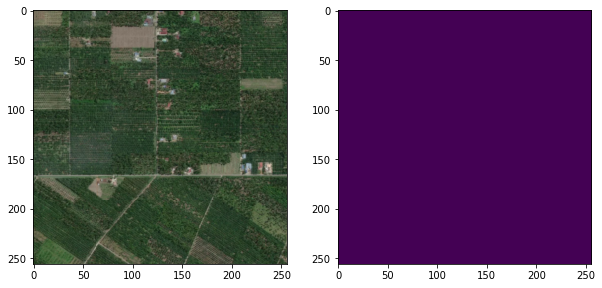

In [15]:
%%time

f = files[10]
f_mask = f.replace('-pic/', '-mask/')
image = (np.load(f) * 255.0).astype(np.uint8)
mask = np.load(f_mask)
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


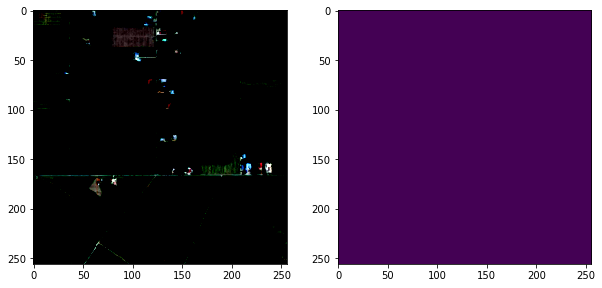

In [16]:
def augmentation(image, mask):
    if random.random() > 0.5:
        segmap = SegmentationMapsOnImage(mask.astype(np.int32), shape=image.shape)
        img = image
        images_aug_i, segmaps_aug_i = seq(image=img, segmentation_maps=segmap)
        seg = segmaps_aug_i.draw()[0][:, :, :1]
        seg[seg > 0] = 1
        seg = seg.astype(np.float32)
        image = images_aug_i
        mask = seg
    image = preprocess_input(image)
    return image, mask

image, mask = augmentation(image, mask)
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 36.6 ms, sys: 0 ns, total: 36.6 ms
Wall time: 35.1 ms


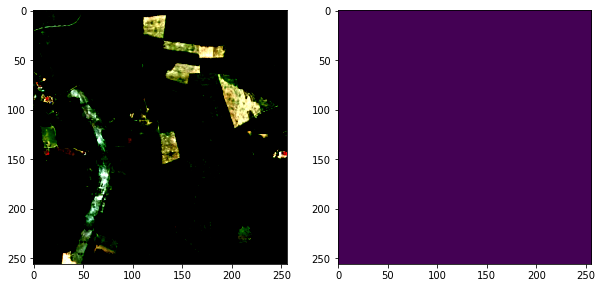

In [17]:
%%time

f = random.choice(files)
f_mask = f.replace('-pic/', '-mask/')
image = (np.load(f) * 255.0).astype(np.uint8)
mask = np.load(f_mask)
image, mask = augmentation(image, mask)
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

In [18]:
from sklearn.utils import shuffle
import tensorflow as tf

def generate():
    files = glob('*-pic/*.npy')
    while True:
        files = shuffle(files)
        for f in files:
            f_mask = f.replace('-pic/', '-mask/')
            image = (np.load(f) * 255.0).astype(np.uint8)
            mask = np.load(f_mask)
            image, mask = augmentation(image, mask)
            
            yield {
                'image': image,
                'mask': mask,
            }
            
dataset = tf.data.Dataset.from_generator(
    generate,
    {
        'image': tf.float32,
        'mask': tf.float32,
    },
    output_shapes={
        'image': tf.TensorShape([256, 256, 3]),
        'mask': tf.TensorShape([256, 256, 1]),
    },
)
dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [19]:
dataset = dataset.make_one_shot_iterator().get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [20]:
dataset

{'image': <tf.Tensor 'IteratorGetNext:0' shape=(256, 256, 3) dtype=float32>,
 'mask': <tf.Tensor 'IteratorGetNext:1' shape=(256, 256, 1) dtype=float32>}

In [21]:
sess = tf.Session()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


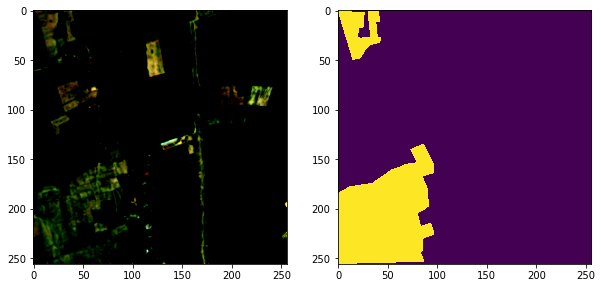

In [22]:
while True:
    r = sess.run(dataset)
    uniques = np.unique(r['mask'][:,:,0], return_counts = True)
    if np.unique(r['mask'][:,:,0], return_counts = True)[0].shape[0] == 2:
        break
        
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(r['image'])
plt.subplot(1,2,2)
plt.imshow(r['mask'][:,:,0])